In [1]:
%matplotlib inline

**Recuperando o que foi feito na introdução...**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split

# Lendo csv
csv_data = pd.read_csv("data/spambase.csv")

# Copiando os dados do csv
data = csv_data.values.copy()

# Embaralhando os dados para garantir aleatoriedade entre as amostras
# np.random.shuffle(data)

# Separando atributos de classes
x = data[:, :-1]  # x tem apenas valores entre a primeira e penúltima coluna
y = data[:, -1]  # y tem os valores da última coluna

# 70% dos dados serão utilizados para treinamento e 30% para o teste
# A divisão será estratificada, serão mantidas as proporções de spam e não spam em cada grupo
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, train_size=0.7, stratify=y)

Uma função para criar um arquivo *.dot* que representa a árvore e o converte em uma imagem do tipo *.png*. Infelizmente ele vai funcionar apenas no linux após instalar o (graphviz)... :/

In [3]:
import subprocess
from sklearn.tree import export_graphviz

def create_dot(classificador, nome):
    with open("%s.dot" % nome, 'w') as f:
        export_graphviz(classificador, out_file=f,)
    command = ["dot", "-Tpng", "%s.dot" % nome, "-o", "%s.png" % nome]
    subprocess.check_call(command)


___
## 3. Classificador Àrvore de Decisão


Ao contrário dos métodos anteriores, uma árvore de decisão é capaz de lidar com atributos numéricos 
ou não numéricos (como uma classe), sem importar a natureza do valor.

Dos classificadores do tipo árvore existente no scikit-learn, vamos utilizar o *DecisionTreeClassifier*. Nesse classificador é possível utilizar tanto o Gini quanto a Entropia como critério de divisão de um nó. Então, vamos exeprimentar como cada critério influenciará no resultado do classificador.


### 3.1 Utilizando o Gini como critério de divisão

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


# Classificando com uma árvore de decisão
cls_dt_gini = DecisionTreeClassifier(criterion="gini", random_state=9, max_depth=9)
# Treinamento
cls_dt_gini.fit(x_treino, y_treino)
# Predição
y_dt_pred = cls_dt_gini.predict(x_teste)

print "Árvore de decisão"
print classification_report(y_dt_pred, y_teste)


Árvore de decisão
             precision    recall  f1-score   support

        0.0       0.95      0.92      0.93       868
        1.0       0.87      0.92      0.89       512

avg / total       0.92      0.92      0.92      1380



Sem qualquer alteração sobre o conjunto de dados, o classificador já foi capaz de dar um resultado interessante, melhor que o Naive Bayes. Isso se deve muito ao fato de que todas as informações disponíveis foram utilizadas no processo de treinamento.

Uma coisa bacana desse classificador é a possibilidade de converter a estrura da árvore criada por ele em uma imagem. Com isso, além visualizar a árvore gerada é possível verificar matemáticamente a sua corretude.

Abaixo, podemos ver a árvore utilizada pelo classificador **(clique com o botão direito do mause sobre a imagem e escolha a opção "abrir em nova aba" para ter uma melhor visualização).**

In [13]:
create_dot(cls_dt_gini, "tree_gini")

![](/files/tree_gini.png)

### 3.1 Utilizando a entropia como critério de divisão

In [6]:
# Classificando com uma árvore de decisão
cls_dt_ent = DecisionTreeClassifier(criterion="entropy", random_state=9, max_depth=9)
# Treinamento
cls_dt_ent.fit(x_treino, y_treino)
# Predição
y_dt_pred = cls_dt_ent.predict(x_teste)

print "Árvore de decisão"
print classification_report(y_dt_pred, y_teste)


Árvore de decisão
             precision    recall  f1-score   support

        0.0       0.97      0.90      0.93       904
        1.0       0.83      0.95      0.89       476

avg / total       0.92      0.92      0.92      1380



Visualizando a árvore.

In [7]:
create_dot(cls_dt_ent, "tree_entropy")

![](/files/tree_entropy.png)

Como podemos verificar a diferênça de desempenho entre os dois critérios é bem pequena, quase imperceptível. E de fato, a grande diferênça entre ambos esta no desempenho, o Gini é mais rápido e mais simples. Estudos já mostraram que a diferênça de precisão é inferior aos 2%.

## 3. Utilizando uma Floresta de Àrvores de Decisão

E se ao invés de uma árvore, utilizássemos uma floresta? Uma coleção de àrvores.

O Random Forest é um meta classificador que utiliza uma coleção de árvores de decisão. O algoritmo Random Forest gera múltiplas árvores de decisão que depois são utilizadas na classificação de novos objetos. O seu final, na predição, é o resultado da combinação dos resultados das suas árvores de decisão.

No scikit Learn temos o RandomForestClassifier.

In [8]:
from sklearn.ensemble import RandomForestClassifier


# Classificando com uma floresta árvores de decisão
cls_rf = RandomForestClassifier(n_estimators=100)
cls_rf.fit(x_treino, y_treino)
y_pred_rf = cls_rf.predict(x_teste)

print "Floresta árvores de decisão"
print classification_report(y_pred_rf, y_teste)

Floresta árvores de decisão
             precision    recall  f1-score   support

        0.0       0.98      0.94      0.96       865
        1.0       0.91      0.96      0.93       515

avg / total       0.95      0.95      0.95      1380



Uma coisa bacana desse meta classificador, é que ele te possibilita verificar a importância que cada atributo teve na construção sua construção. A importância de um atributo será a combinação da importância que ele teve em cada uma das árvores geradas.

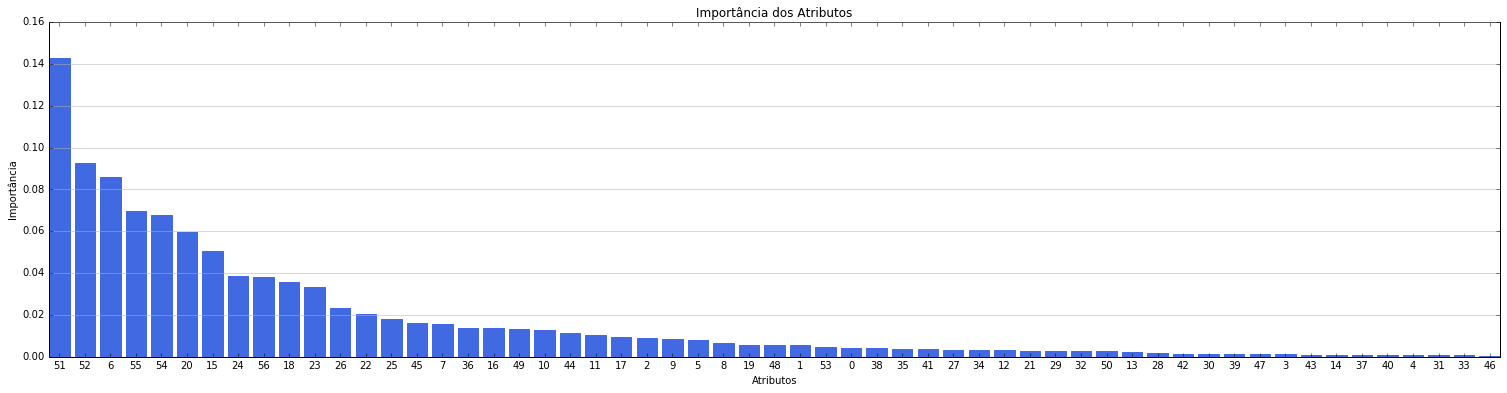

In [9]:
importances = cls_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(26, 6), dpi=200)
plt.title(u"Importância dos Atributos")
plt.grid(b=True, which='both', color='0.7',linestyle='-', axis='y')
plt.xticks(range(len(indices)), indices)
plt.bar(range(len(indices)), importances[indices], color="#4169E1", align="center",edgecolor="#4169E1")
plt.xlabel(u"Atributos")
plt.ylabel(u"Importância")
plt.show()

De posse dessa informação, podemos tentar eliminar os atributos que tiveram pouca importância. Vamos ver o que acontece...

In [10]:
atributos_pouca_import = np.where(importances < 0.007)
print "Foram descartados %d atributos!!!" % len(atributos_pouca_import[0])
i_x_teste = np.delete(x_teste, atributos_pouca_import, 1)
i_x_treino = np.delete(x_treino, atributos_pouca_import, 1)

Foram descartados 31 atributos!!!


In [11]:
cls_rf = RandomForestClassifier(n_estimators=100)
cls_rf.fit(i_x_treino, y_treino)
y_pred_rf = cls_rf.predict(i_x_teste)

print "Floresta árvores de decisão"
print classification_report(y_pred_rf, y_teste)

Floresta árvores de decisão
             precision    recall  f1-score   support

        0.0       0.97      0.94      0.96       866
        1.0       0.91      0.96      0.93       514

avg / total       0.95      0.95      0.95      1380



O resultado é que conseguimos o mesmo resultado com menos da metade dos dados! Ou seja, **nem todas os atributos fornecidos são necessários!** O classificador pode ser ainda mais simples!

Sabendo dessa informação, vamos tentar novamente o DecisionTreeClassifier (um classificador mais simples):

In [12]:
cls_dt_r_gini = DecisionTreeClassifier(criterion="gini", random_state=9, max_depth=9)
# Treinamento
cls_dt_r_gini.fit(i_x_treino, y_treino)
# Predição
y_dt_pred = cls_dt_r_gini.predict(i_x_teste)

print "Árvore de decisão"
print classification_report(y_dt_pred, y_teste)

Árvore de decisão
             precision    recall  f1-score   support

        0.0       0.96      0.91      0.93       886
        1.0       0.85      0.93      0.89       494

avg / total       0.92      0.91      0.92      1380



O resultado foi praticamente o mesmo obtido quando DecisionTreeClassifier foi executado. O que prova que realemnete nem todas os atributos fornecidos são necessários!